In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
trainData_dir = '../Data/Train'
testData_dir = '../Data/Test'

train_dataGen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_gen = train_dataGen.flow_from_directory(
    trainData_dir,
    target_size = (224, 224),
    batch_size = 30,
    class_mode = 'categorical',
)

val_gen = train_dataGen.flow_from_directory(
    testData_dir, 
    target_size = (224, 224),
    batch_size = 30,
    class_mode = 'categorical',
)

print(train_gen.class_indices)

Found 1944 images belonging to 15 classes.
Found 1944 images belonging to 15 classes.
{'Bear': 0, 'Bird': 1, 'Cat': 2, 'Cow': 3, 'Deer': 4, 'Dog': 5, 'Dolphin': 6, 'Elephant': 7, 'Giraffe': 8, 'Horse': 9, 'Kangaroo': 10, 'Lion': 11, 'Panda': 12, 'Tiger': 13, 'Zebra': 14}


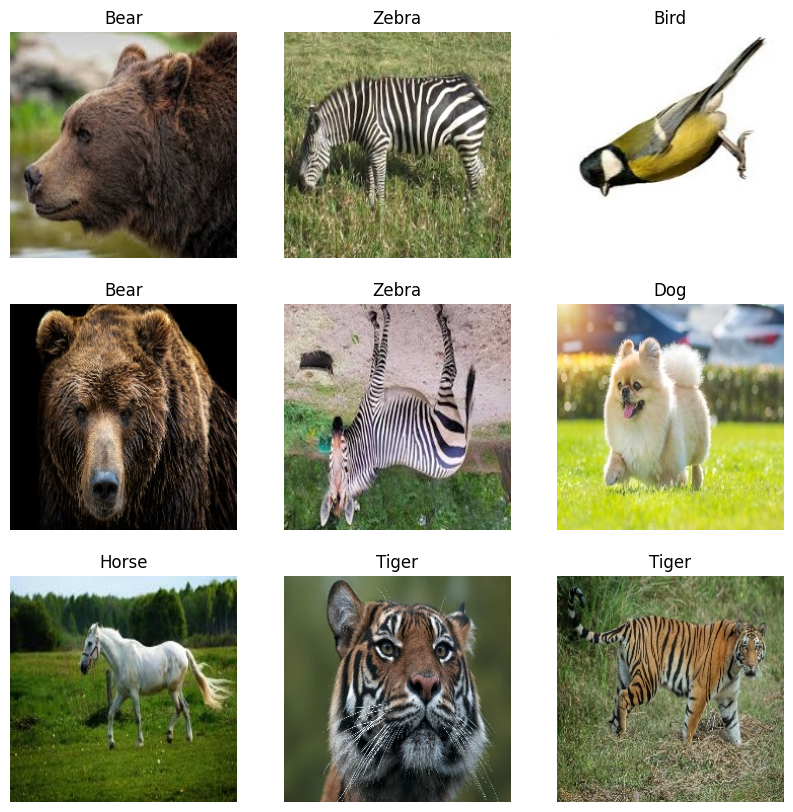

(30, 15)

In [3]:
x, y = next(train_gen)
plt.figure(figsize= (10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x[i])
    plt.title(list(train_gen.class_indices.keys())[np.argmax(y[i])])
    plt.axis('off')
plt.show()
x.shape
y.shape

In [4]:
base_model = MobileNetV2(weights= 'imagenet', include_top= False, input_shape= (224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs= base_model.input, outputs= preds)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer= Adam(0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
early_stop = EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)

history = model.fit(train_gen, validation_data=val_gen, epochs= 10, callbacks= [early_stop])

c:\Users\HP\anaconda3\envs\myvenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 348s 5s/step - accuracy: 0.7279 - loss: 0.9260 - val_accuracy: 0.9203 - val_loss: 0.2916
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9372 - loss: 0.2295 - val_accuracy: 0.9733 - val_loss: 0.1274
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9660 - loss: 0.1356 - val_accuracy: 0.9799 - val_loss: 0.0873
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9856 - loss: 0.0768 - val_accuracy: 0.9918 - val_loss: 0.0486
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9928 - loss: 0.0479 - val_accuracy: 0.9995 - val_loss: 0.0252
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9985 - loss: 0.0276 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9995 - loss: 0.0188 - val_accuracy: 0.9995 - val_loss: 0.0164
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9995 - loss: 0.0163 - val_accuracy: 1.0000 - val_los

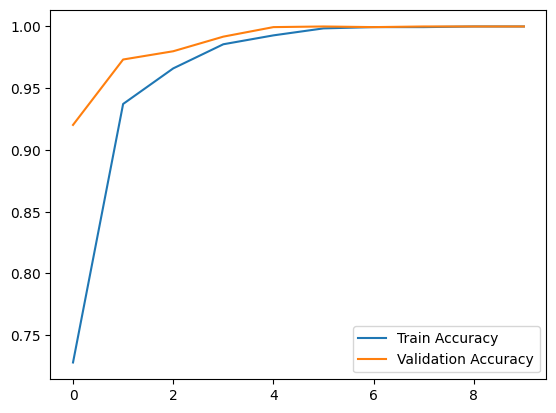

In [6]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')
plt.legend()
plt.show()

model.save('../Models/animal_classification.h5')

In [7]:
import gradio as gr 
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model("../Models/animal_classification.h5")
labels = ['Bear','Bird','Cat','Cow','Deer','Dog','Dolphin','Elephant','Giraffe','Horse','Kangaroo','Lion','Panda','Tiger','Zebra']

def predict(img):
    img=tf.image.resize(img,(224,224)).numpy()
    img = np.expand_dims(np.array(img)/225.0, axis=0)
    preds = model.predict(img)
    return {labels[i]: float(preds[0][i]) for i in range(len(labels))}

gr.Interface(fn=predict, inputs="image", outputs="label").launch()

c:\Users\HP\anaconda3\envs\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
